# Retrieve and plot European air quality forecast data from the Atmosphere Data Store

<img src="https://ads.atmosphere.copernicus.eu/themes/custom/baby_blue/logo.svg" width=140> 
This notebook demonstrates how to retrieve NetCDF data from the Atmosphere Data Store (https://ads.atmosphere.copernicus.eu/) (ADS) and create time series plots and maps using xarray and Cartopy libraries.

First, let's define some general purpose variables

In [10]:
DATADIR = '../eodata/cams/ex2'
DATE = "2020-11-09"
hours = [str(h) for h in range(97)]
models = [ 'chimere', 'dehm', 'emep', 'ensemble', 'euradim', 'gemaq', 'lotos', 'match', 'mocage', 'silam']

Next, we will retrieve the data from the ADS by using the cdsapi Python library. 

https://ads.atmosphere.copernicus.eu/api-how-to 

**To be able to run the data retrieval example below you will need to register on the Atmosphere Data Store (https://ads.atmosphere.copernicus.eu/) and then visit this page: https://ads.atmosphere.copernicus.eu/api-how-to to obtain the API authentication key.**

If you want to speed up the process, you can use the files which are already available on the LTPY training platform.

In [12]:
DOWNLOAD = False

if DOWNLOAD:

    import cdsapi
    # to supress SSL warnings
    import urllib3
    
    # enter your ADS authentication key
    URL = "https://ads.atmosphere.copernicus.eu/api/v2"
    KEY = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    c = cdsapi.Client(url=URL, key=KEY)

    for model in models:  
        c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'model': model,
        'date': DATE,
        'format': 'netcdf',
        'variable': 'nitrogen_dioxide',
        'type': 'forecast',
        'time': '00:00',
        'leadtime_hour': hours,
        'level': '0',
    },
    f'{DATADIR}/air_quality_{model}_{DATE}.nc')


Let's inspect one file

In [7]:
import xarray as xr

dset = xr.open_dataset(f'{DATADIR}/air_quality_ensemble_2020-11-09.nc')
print(dset)

<xarray.Dataset>
Dimensions:    (latitude: 420, level: 1, longitude: 700, time: 97)
Coordinates:
  * longitude  (longitude) float32 335.05 335.15 335.25 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 4 days 00:00:00
Data variables:
    no2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        NO2 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20201109+[0H_96H]
    summary:      ENSEMBLE model hourly FORECAST of NO2 concentration at the ...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)


Text(0.5, 1.0, 'CAMS air quality NO2 forecast BASETIME=2020-11-09 LAT=45.47 LON=9.19')

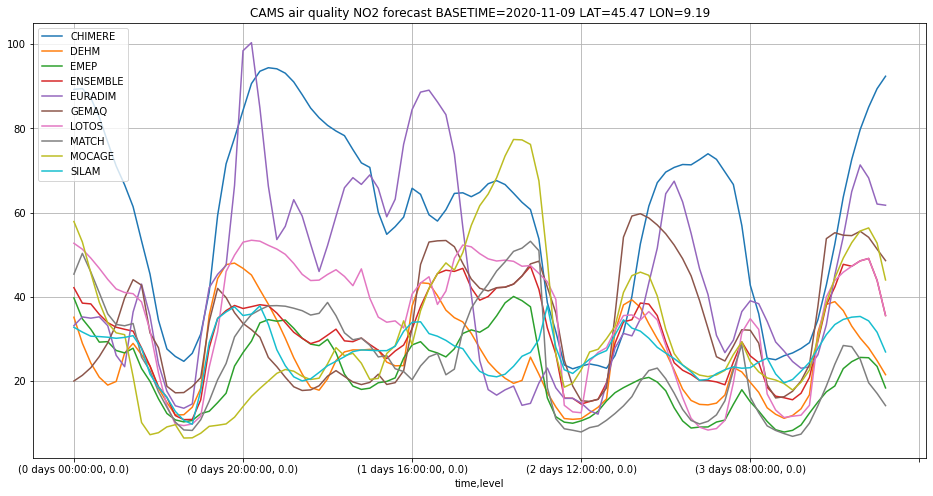

In [8]:
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs

DATE = "2020-11-09"
models = [ 'chimere', 'dehm', 'emep', 'ensemble', 'euradim', 'gemaq', 'lotos', 'match', 'mocage', 'silam']
param = "NO2"
lat = 45.47
lon = 9.19

fig = plt.figure(figsize=(16,8))
ax = fig.subplots()

for model in models:
    dset = xr.open_dataset(f'{DATADIR}/air_quality_{model}_{DATE}.nc')
# print(dset)
    dd = dset["no2_conc"].interp(latitude=45.3, longitude=9.35).to_dataframe()
    dd.no2_conc.plot(ax=ax, label=model.upper())

plt.grid()
plt.legend()
plt.title(f"CAMS air quality {param} forecast BASETIME={DATE} LAT={lat} LON={lon}")

/opt/conda/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/conda/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


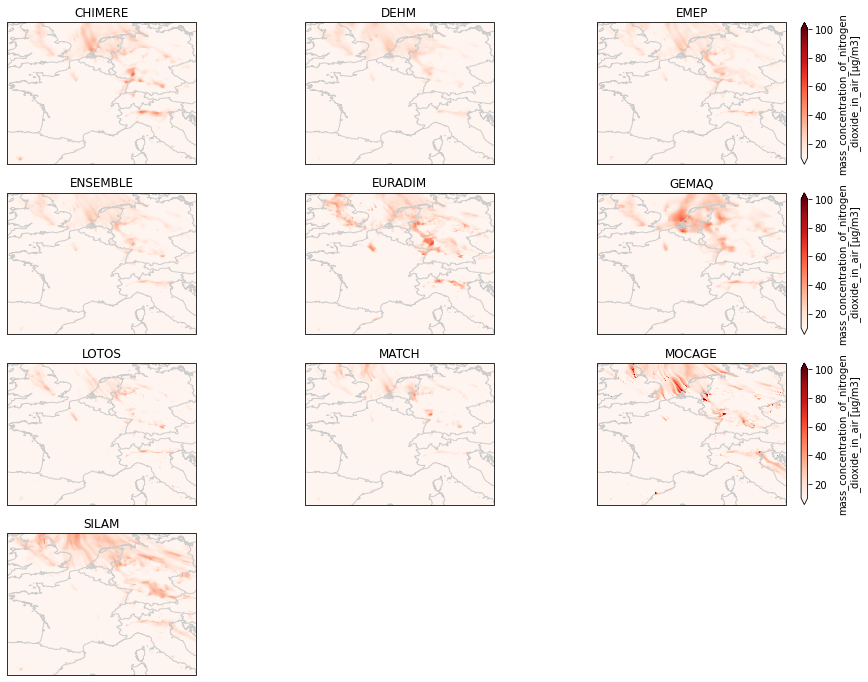

In [9]:
BORDER_COLOUR = "#cccccc"
NCOLS = 3
NROWS = len(models) // NCOLS + 1

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(16,12), subplot_kw={'projection': ccrs.PlateCarree()})

for ii, model in enumerate(models):
    dset = xr.open_dataset(f'{DATADIR}/air_quality_{model}_{DATE}.nc')
    dset = dset.assign_coords(longitude=(((dset.longitude + 180) % 360) - 180)).sortby('longitude')    

    # x and y indices of the subplot to use for this model
    iy = ii // NCOLS
    ix = ii % NCOLS
    # show the colorbar only in the last column
    show_cbar = NCOLS - ix == 1
    p = dset["no2_conc"][13][0].plot.pcolormesh(ax=axes[iy, ix], vmin=10, vmax=100., 
                                                add_colorbar=show_cbar, extend='both', cmap='Reds', 
                                                transform=ccrs.PlateCarree())
    axes[iy, ix].set_title(model.upper())
    axes[iy, ix].xaxis.set_label_text("")
    axes[iy, ix].yaxis.set_label_text("")
    axes[iy, ix].set_extent([-5, 15, 40, 55])
    axes[iy, ix].add_feature(cartopy.feature.BORDERS, color=BORDER_COLOUR)
    axes[iy, ix].coastlines(color=BORDER_COLOUR)
    
# let's remove axes on the empty subplots
for iix in range(ix + 1, NROWS - 1):
    axes[iy, iix].axis('off')

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=.0, hspace=0.2)